In [10]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import sympy as sp
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
from tqdm import *
jax.config.update("jax_enable_x64", True)

### THE ITERATION PARAMETERs
#physical parameters
delta = 0.024 #interface width
Lambda = jnp.sqrt(2)*delta/4
g_ab = [3e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 1.1e-2, 1.2e-2, 1.3e-2, 1.4e-2]
gamma_bc = 1e-2
gamma_ca = 1e-2  

image_num = 50
N = 128 #num of nodes
r = jnp.linspace(0, 1, N+1)
r_mid = (r[1:] + r[:-1]) / 2
dr = r_mid[1] - r_mid[0]


k = 2*jnp.pi*jnp.fft.fftfreq(N, d=dr)
kx, ky, kz = jnp.meshgrid(k, k, k)
k_square = kx**2 + ky**2 + kz**2

In [11]:
def cal_theoretical_angle(g_ab):
    gamma_ca = 1e-2
    gamma_bc = 1e-2
    x, y = sp.symbols('x y')
    eq1 = gamma_ca*sp.cos(x) + gamma_bc*sp.cos(y) - g_ab
    eq2 = gamma_bc*sp.sin(y) - gamma_ca*sp.sin(x)
    solution = sp.solve([eq1, eq2], (x, y))
    angle = solution[-1]
    return angle

def cal_shapefactor(Angle):
    theta = float(Angle[0])
    phi = float(Angle[1])
    s1 = (2+jnp.cos(theta))*jnp.power(1-jnp.cos(theta), 2)/4
    s2 = (2+jnp.cos(phi))*(1-jnp.cos(phi))*jnp.power(jnp.sin(theta), 3)
    s3 = 4*(1+jnp.cos(phi))*jnp.sin(phi)
    S = s1 + (s2/s3)
    return S

sf = []
for gamma_ab in g_ab:
    angle = cal_theoretical_angle(g_ab=gamma_ab)
    sf.append(float(cal_shapefactor(Angle=angle)))

print(sf)

[0.7766875, 0.5635000000000001, 0.49643750000000053, 0.43200000000000033, 0.3705625, 0.3125, 0.2581875000000002, 0.2080000000000002, 0.1623124999999998, 0.12150000000000002]


In [12]:
def cal_gradsquare(x):
    xh = jnp.fft.fftn(x, axes=(1,2,3))
    p = jnp.fft.ifftn(k_square*xh, axes=(1,2,3)).real
    return x*p


def main(case):
    eb = []
    for gamma_ab in tqdm(g_ab):
        if gamma_ab > 1e-2:
            Aa = (9*gamma_ab + 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
            Ab = (9*gamma_ab - 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
            Ac = 3*jnp.sqrt(2)*gamma_ca/Lambda - 4*Aa/3 - Ab/3 
        else:
            Ab = jnp.sqrt(2)*(9*gamma_bc + 12*(gamma_ab - gamma_ca))/(8*Lambda)
            Ac = jnp.sqrt(2)*(9*gamma_bc - 12*(gamma_ab - gamma_ca))/(8*Lambda)
            Aa = 3*jnp.sqrt(2)*gamma_ab/Lambda - 4*Ab/3 - Ac/3
        A = jnp.array([Aa, Ab, Ac])
        C = jnp.max(A + jnp.roll(A, 1))/6

        u = jnp.load(f"Nucleation_ZTS/TernaryMix/3d/Output/SymmetricCase/Data-InterfaceWidth-0.024/gamma_ab-{gamma_ab}/{case}/concentration.npy")
        ua = u[0]
        ub = u[1]
        uc = u[2]

        bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
        
        Wa = jnp.power(Lambda, 2)*(Aa + C)
        Wb = jnp.power(Lambda, 2)*(Ab + C)
        Wc = jnp.power(Lambda, 2)*(Ac + C)

        interface_term = Wa*cal_gradsquare(ua)/2 + Wb*cal_gradsquare(ub)/2 + Wc*cal_gradsquare(uc)/2

        G = jnp.mean(bulk_term + interface_term, axis=(1,2,3))
        critical_index = jnp.argmax(G)
        barrier = G[critical_index] - G[0]
        eb.append(float(barrier))

    return eb

eb_het = main(case="heterogeneous")
eb_hom = main(case="homogeneous")
print(f"Het:{eb_het}")
print(f"Hom:{eb_hom}")

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Het:[0.00015823110702376138, 0.00013131565512078044, 0.00012093024910631717, 0.00010999007031974734, 9.917749308226143e-05, 8.796129612822015e-05, 7.678807375241514e-05, 6.562384139950292e-05, 5.3972064782296936e-05, 4.1869480888929306e-05]
Hom:[0.00021422809266827617, 0.00026488162290216194, 0.0002879014433073701, 0.00031484342138859284, 0.00034808851569620783, 0.0003892128943211136, 0.00044633887867118194, 0.0006409016800828019, 0.0007526391065696726, 0.00096437528974316]


In [13]:
from scipy.optimize import fsolve

g_sf_dict = dict(zip(g_ab, sf))
def cal_theo_eb_hom(g_ab):
    ## THE ITERATION PARAMETERs
    #physical parameters
    delta = 0.024 #interface width
    Lambda = jnp.sqrt(2)*delta/4
    N = 128

    gamma_ab = g_ab #interface energy between components A,B
    gamma_bc = 1e-2
    gamma_ca = 1e-2
    gamma = jnp.array([gamma_ab, gamma_bc, gamma_ca])

    if gamma_ab > 1e-2:
        Aa = (9*gamma_ab + 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
        Ab = (9*gamma_ab - 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
        Ac = 3*jnp.sqrt(2)*gamma_ca/Lambda - 4*Aa/3 - Ab/3 
    else:
        Ab = jnp.sqrt(2)*(9*gamma_bc + 12*(gamma_ab - gamma_ca))/(8*Lambda)
        Ac = jnp.sqrt(2)*(9*gamma_bc - 12*(gamma_ab - gamma_ca))/(8*Lambda)
        Aa = 3*jnp.sqrt(2)*gamma_ab/Lambda - 4*Ab/3 - Ac/3
    A = jnp.array([Aa, Ab, Ac])
    C = jnp.max(A + jnp.roll(A, 1))/6

    rc = 0.2 # the final radius of conponent C
    fai = 4*jnp.pi*jnp.power(rc,3)/3 #The mean concentration of component c
    eps = 1e-14 #

    def ChemicalPotential(i, ua, ub, uc):
        P = jnp.power(1-ua, 2)*jnp.power(1-ub, 2)*jnp.power(1-uc, 2)
        S = jnp.power(ua, 2)+jnp.power(ub, 2)+jnp.power(uc, 2)
        u = [ua, ub, uc]
        mu_i = 2*A[i]*u[i]*(1 - u[i])*(1 - 2*u[i]) + 2*C*(u[i]*(S - u[i]**2) - (1-u[i])*(P + eps)/(jnp.power(1-u[i], 2) + eps))
        return mu_i

    #compute the free energy (bulk + interface)
    def energy(ua, ub, uc):
        bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
        return bulk_term
    
    def get_mean_ua(ua0):
        assert ua0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(10, 60, 5):
        #for i in range(10, 128, 10):
            c.append(np.mean(ua0[:, :, k]))
        return sum(c)/len(c)

    def get_mean_ub(ub0):
        assert ub0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(10, 60, 5):
        #for i in range(10, 128, 10):
            c.append(np.mean(ub0[:, :, k]))
        return sum(c)/len(c)
    
    def get_mean_uc(uc0):
        assert uc0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(10, 120, 5):
            c.append(np.mean(uc0[:, :, k]))
        return sum(c)/len(c)

    def critical_Delta_F():
        u = jnp.load(f"Nucleation_ZTS/TernaryMix/3d/Output/SymmetricCase/Data-InterfaceWidth-0.024/gamma_ab-{g_ab}/homogeneous/concentration.npy")
        ua0 = u[0, 0, :, :, :]
        ub0 = u[1, 0, :, :, :]
        uc0 = u[2, 0, :, :, :]
        mean_uc = get_mean_uc(uc0)
        mean_ua = get_mean_ua(ua0)
        mean_ub = get_mean_ub(ub0)
        print(f"case gamma_ab = {g_ab}, mean_ua = {mean_ua}, mean_ub = {mean_ub}, mean_uc = {mean_uc}, sum {mean_ua+ mean_ub + mean_uc}")

        ua0 = mean_ua
        ub0 = mean_ub
        uc0 = mean_uc

        ua1 = 0
        ub1 = 0
        uc1 = 1

        ua2 = 1
        ub2 = 0
        uc2 = 0

        f0 = energy(ua=ua0, ub=ub0, uc=uc0) 
        f1 = energy(ua=ua1, ub=ub1, uc=uc1)

        mu_a0 = ChemicalPotential(0, ua=ua0, ub=ub0, uc=uc0)
        mu_b0 = ChemicalPotential(1, ua=ua0, ub=ub0, uc=uc0)
        mu_c0 = ChemicalPotential(2, ua=ua0, ub=ub0, uc=uc0)
        
        df = f1 - f0
        k = (ua2 - ua1)*mu_a0 + (uc2 - uc1)*mu_c0 + (ub2 - ub1)*mu_b0
        def equation(x):
            return (df + k)*x - 16*jnp.pi*k*(x**4)/3 + 2*gamma_ca
        Rc = fsolve(equation, 0)[0]
        
        DFc = (f1 - f0)*(4*jnp.pi*(Rc**3)/3) + ((ua2 - ua1)*mu_a0 + (ub2 - ub1)*mu_b0 + (uc2 - uc1)*mu_c0)*(4*jnp.pi*(Rc**3)/3)*(1 - 8*jnp.pi*(Rc**3)/3) + 4*jnp.pi*(Rc**2)*gamma_ca
        
        return Rc, DFc

    theo_r, theo_eb_hom = critical_Delta_F()
    print(f"极大值对应的r值:{theo_r}, 极大值:{theo_eb_hom}\n")

    return float(theo_r), float(theo_eb_hom)




theo_hom = []
theo_het = []
theo_cr_hom = []
theo_cr_het = []
for gamma_ab in tqdm(g_ab):
    theo_r, theo_eb_hom = cal_theo_eb_hom(g_ab=gamma_ab)
    theo_eb_het = theo_eb_hom*g_sf_dict[gamma_ab]
    theo_hom.append(theo_eb_hom)
    theo_het.append(theo_eb_het)
    theo_cr_hom.append(theo_r)

print(f"Theo Het:{theo_het}")
print(f"Theo Hom:{theo_hom}")

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

case gamma_ab = 0.003, mean_ua = 0.9826557268267961, mean_ub = -0.01557307681860469, mean_uc = 0.03319281557761692, sum 1.0002754655858084
极大值对应的r值:0.07056656560526023, 极大值:0.00020737220482061212



 20%|██        | 2/10 [00:02<00:10,  1.31s/it]

case gamma_ab = 0.006, mean_ua = 0.9837877002594053, mean_ub = -0.014684373221795725, mean_uc = 0.03307107735114693, sum 1.0021744043887566
极大值对应的r值:0.07733216855597247, 极大值:0.0002485770880201458



 30%|███       | 3/10 [00:03<00:09,  1.31s/it]

case gamma_ab = 0.007, mean_ua = 0.9841167112451223, mean_ub = -0.014408618532301933, mean_uc = 0.03301658176100654, sum 1.002724674473827
极大值对应的r值:0.08007451454665182, 极大值:0.00026629016330528366



 40%|████      | 4/10 [00:05<00:07,  1.31s/it]

case gamma_ab = 0.008, mean_ua = 0.9844358844566579, mean_ub = -0.014141987346044807, mean_uc = 0.03295198831383098, sum 1.0032458854244442
极大值对应的r值:0.08312220421292513, 极大值:0.0002866501440205979



 50%|█████     | 5/10 [00:06<00:07,  1.44s/it]

case gamma_ab = 0.009, mean_ua = 0.9847480111861179, mean_ub = -0.013881570326981302, mean_uc = 0.032874210969715885, sum 1.0037406518288525
极大值对应的r值:0.08652540227016023, 极大值:0.00031021458111440373



 60%|██████    | 6/10 [00:08<00:05,  1.48s/it]

case gamma_ab = 0.01, mean_ua = 0.9850560572547821, mean_ub = -0.013624604174783578, mean_uc = 0.03277874512633798, sum 1.0042101982063365
极大值对应的r值:0.0903495162423824, 极大值:0.0003377227139780578



 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

case gamma_ab = 0.011, mean_ua = 0.9851274126133032, mean_ub = -0.013570043783735572, mean_uc = 0.03259184249590393, sum 1.0041492113254715
极大值对应的r值:0.09420065410222983, 极大值:0.00036650700552245507



 80%|████████  | 8/10 [00:11<00:02,  1.50s/it]

case gamma_ab = 0.012, mean_ua = 0.9852238639601734, mean_ub = -0.013495849791008218, mean_uc = 0.032344637465556395, sum 1.0040726516347216
极大值对应的r值:0.098543177589372, 极大值:0.0004002388235628215



 90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

case gamma_ab = 0.013, mean_ua = 0.9853606698755935, mean_ub = -0.013389798341952442, mean_uc = 0.03200400062342439, sum 1.0039748721570654
极大值对应的r值:0.10356165524109388, 极大值:0.0004408605434658775



100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

case gamma_ab = 0.014, mean_ua = 0.9855673375816743, mean_ub = -0.01322794069884001, mean_uc = 0.03150968559812847, sum 1.0038490824809627
极大值对应的r值:0.10960141325357134, 极大值:0.0004919981384474219

Theo Het:[0.00016106339933160917, 0.00014007318909935217, 0.0001321964229458669, 0.0001238328622168984, 0.00011495389071420623, 0.00010553834811814307, 9.462752748832894e-05, 8.324967530106695e-05, 7.155717696130515e-05, 5.977777382136178e-05]
Theo Hom:[0.00020737220482061212, 0.0002485770880201458, 0.00026629016330528366, 0.0002866501440205979, 0.00031021458111440373, 0.0003377227139780578, 0.00036650700552245507, 0.0004002388235628215, 0.0004408605434658775, 0.0004919981384474219]


low:0.04902493502545419
 high:0.6426652729036433
[0.04902494 0.12022674 0.15389059 0.19132297 0.23111398 0.27680673
 0.33366313 0.50772599 0.55819535 0.64266527]


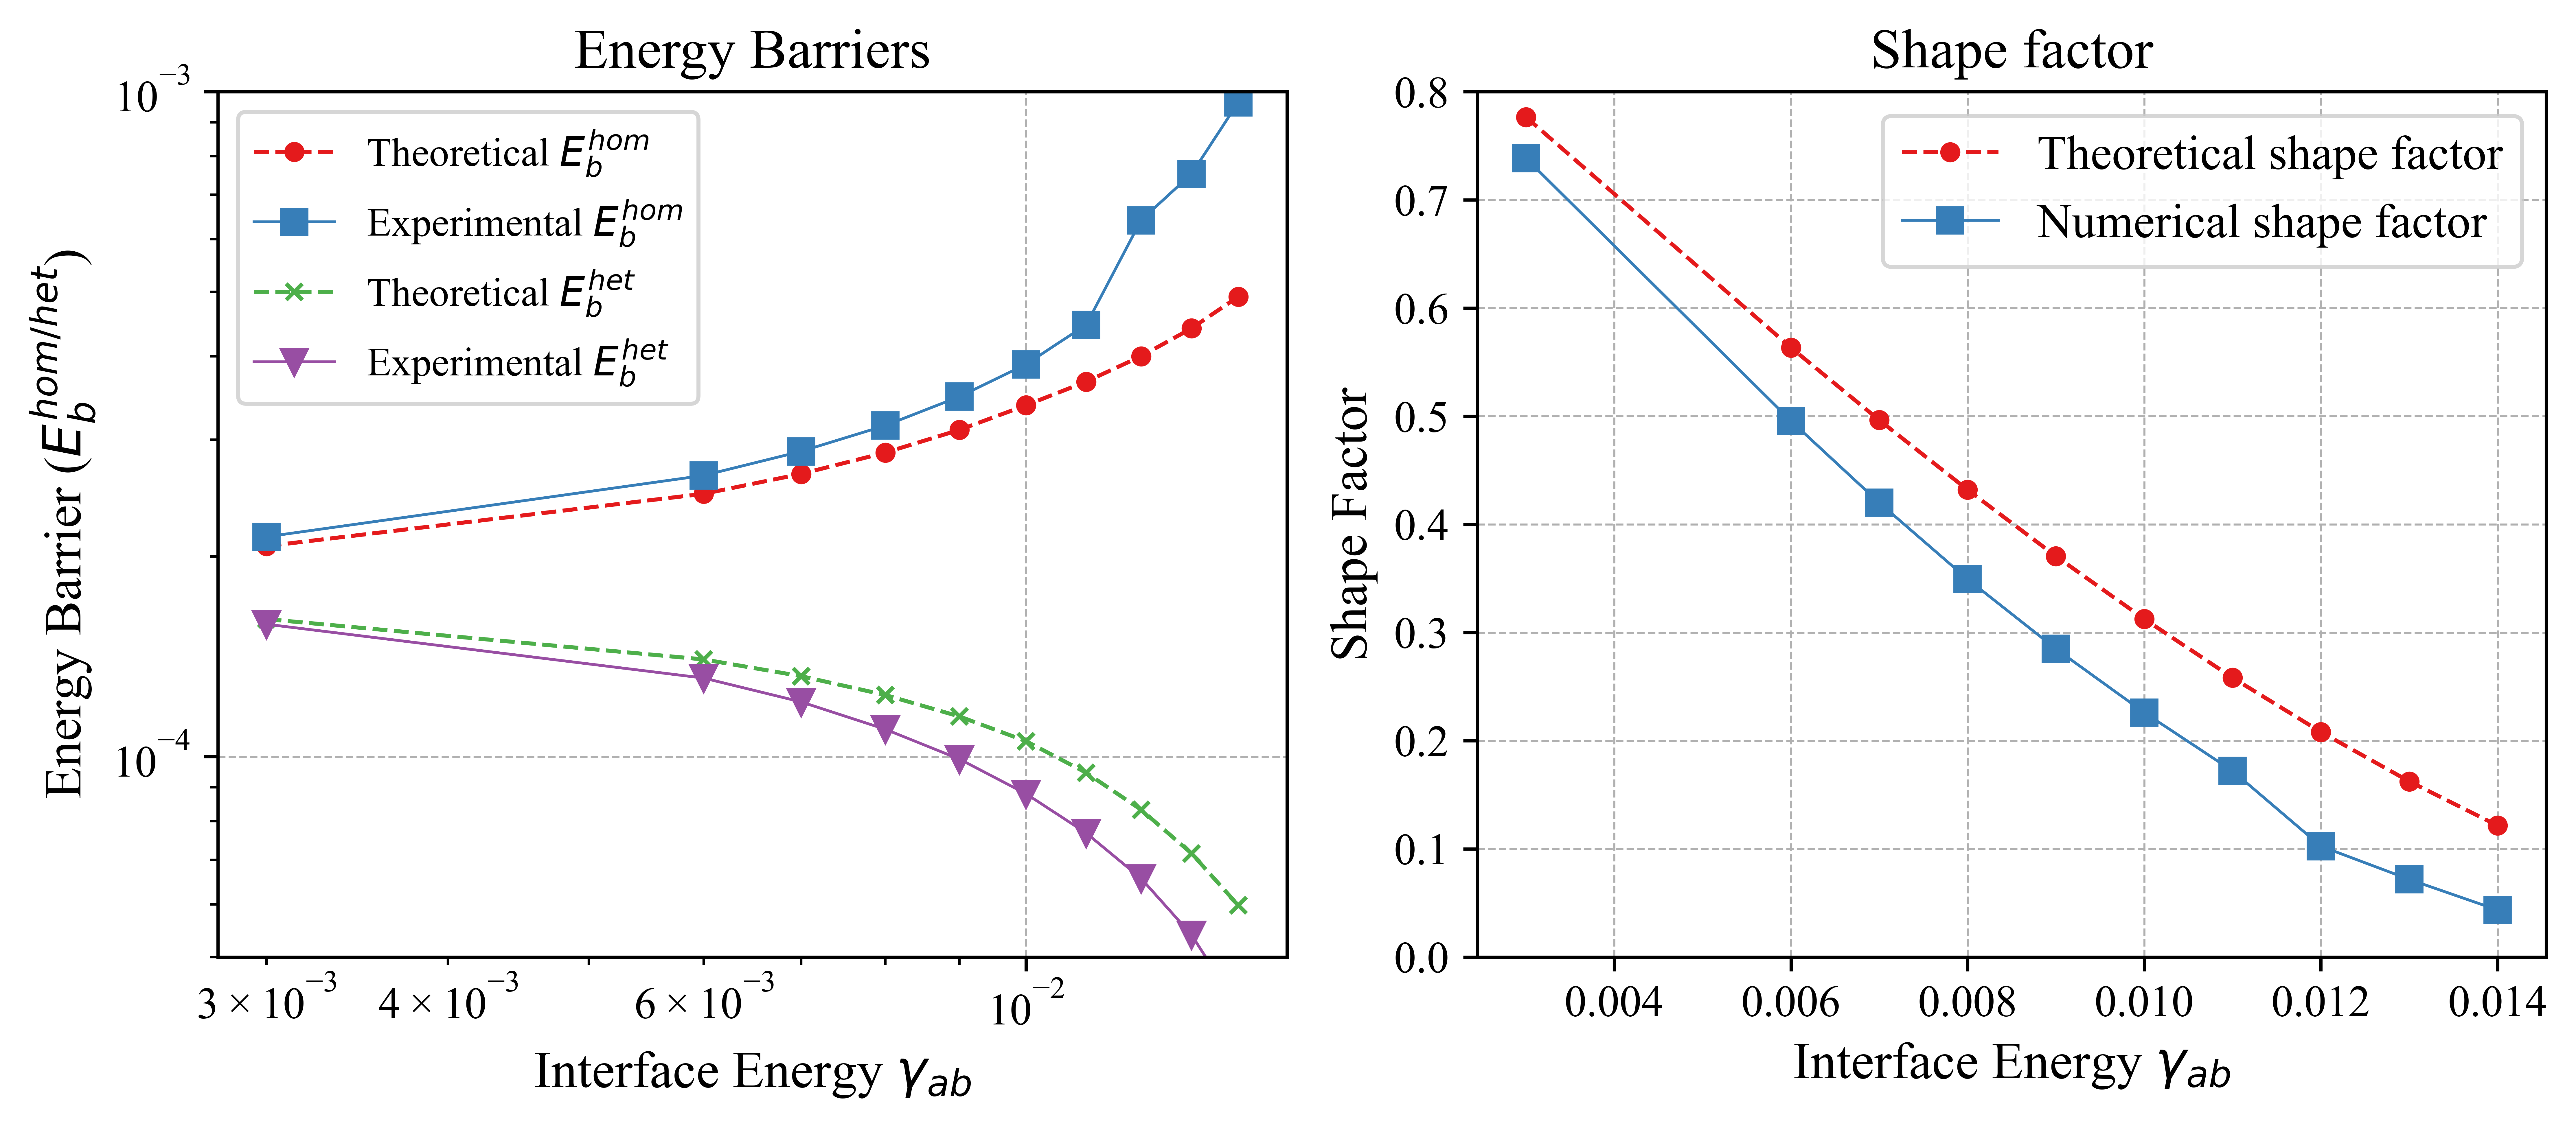

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pylab as pylabs
from matplotlib.ticker import ScalarFormatter
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
myparams = {

   'axes.labelsize': '13',

   'xtick.labelsize': '11',

   'ytick.labelsize': '11',

   'lines.linewidth': 1,

   'legend.fontsize': '10',

   'font.family': 'Times New Roman',

   'figure.figsize': '9, 4'  

}
pylabs.rcParams.update(myparams)  

plt.figure(dpi=1000)

plt.subplot(1,2,1)

plt.plot(g_ab, theo_hom, 'o--',  markersize=4, label='Theoretical $E_{b}^{hom}$')
plt.plot(g_ab, eb_hom, 's-',  markersize=6, linewidth=0.7, label='Experimental $E_{b}^{hom}$')
plt.plot(g_ab, theo_het, 'x--',  markersize=4, label='Theoretical $E_{b}^{het}$')
plt.plot(g_ab, eb_het, 'v-',  markersize=6, linewidth=0.7, label='Experimental $E_{b}^{het}$')
#plt.plot(gamma_ab, eb_het_new, '^-',  markersize=6, label='Corrected Experimental $E_{b}^{het}$')
#plt.plot(gamma_ab, theo_het, '+--',  markersize=4, label='Correted Theoretical $E_{b}^{het}$')
plt.ylim(5e-5, 1e-3)
#plt.yticks([9e-6, 1e-5, 3e-5, 5e-5, 7e-5, 9e-5])

plt.xlabel('Interface Energy $\\gamma_{ab}$')
plt.ylabel('Energy Barrier ($E_{b}^{hom / het}$)')
plt.title("Energy Barriers", fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.yscale('log', base=10)
plt.xscale('log', base=10)


interface_energy_vector = np.array(g_ab)
numerical_shape_factor_vector = np.array(eb_het)/np.array(eb_hom)
theoretical_shape_factor_vector = np.array(sf)

plt.subplot(1,2,2)
#plt.scatter(interface_energy_vector, numerical_shape_factor_vector,  marker="^", s=25,label='Numerical shape factor')
plt.plot(interface_energy_vector, theoretical_shape_factor_vector,  "o--", markersize=4, label='Theoretical shape factor')
plt.plot(interface_energy_vector, numerical_shape_factor_vector, "s-", linewidth=0.7, markersize=6, label='Numerical shape factor')
plt.legend(fontsize=12)
plt.title("Shape factor", fontsize=14)
plt.xlabel('Interface Energy $\\gamma_{ab}$')
plt.ylabel('Shape Factor')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 0.8)

plt.tight_layout()
plt.savefig("/home/ms/akrito/string-method-nucleation/correction/3d/sym/results.pdf", dpi=1000, bbox_inches='tight')


relative_err = np.abs(numerical_shape_factor_vector - theoretical_shape_factor_vector)/theoretical_shape_factor_vector
print(f"low:{np.min(relative_err)}\n high:{np.max(relative_err)}")
print(relative_err)

In [16]:
print(list(numerical_shape_factor_vector))

[0.7386104457774175, 0.4957522295507978, 0.42004044063512835, 0.34934847879191677, 0.28492032517619165, 0.22599789835238387, 0.17203985003731873, 0.1023929932451177, 0.07171041779676736, 0.04341616934220734]
